In [1]:

from xbbg import blp

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import requests

import datetime
from dateutil.relativedelta import relativedelta

from io import BytesIO

In [2]:
def hist_data(tickers, start_date, end_date = datetime.date.today(), condition = "PX_CLOSE_1D", rename = True):
    # Return a matrix of prices, with modifiable pricing condition
    data = blp.bdh(tickers, condition, start_date,end_date)
    data = data.dropna()
    if rename == True:
        cols = []
        for col in data.columns:
            cols.append(col[0])
        data.columns = cols
    return data



In [3]:
df = hist_data(tickers = "USDJPY CURNCY", start_date = "2011-01-01")

<AxesSubplot:ylabel='USDJPY CURNCY'>

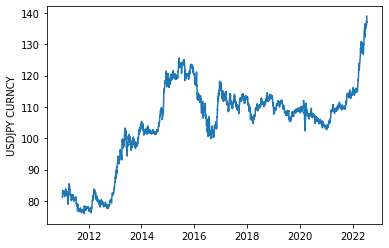

In [4]:
sns.lineplot(x = df.index, y = df.iloc[:,0])

In [5]:
def log_diff(data):
    data = data.apply(lambda x: np.log(x))
    data = data.diff()
    data.dropna(inplace = True)
    return data

In [6]:
def rolling_vol(tickers, lookback_period, lookback_offset = 0, window_size = 30, normalize = True):
    dates = []
    vol = []
    end_date = datetime.date.today()-relativedelta(days = lookback_offset)
    start_date = end_date - relativedelta(days = lookback_period *2.0 + window_size * 2.0)
    data = hist_data(tickers, start_date = start_date, end_date = end_date)
    for x in range(0, lookback_period):
        end = datetime.date.today()-relativedelta(days = lookback_offset)+relativedelta(days = -1*x)
        start = end - relativedelta(days = window_size)
        vector = data[start:end]
        vector = log_diff(vector)
        std = vector.std()
        if normalize:
            std = std * np.sqrt(252)*100
        dates.append(end)
        vol.append(std)
    vol_frame = pd.DataFrame(data = vol, index = dates, columns = data.columns)
    vol_frame.plot(kind = 'line')
    vol_frame.dropna(inplace = True)
    return vol_frame

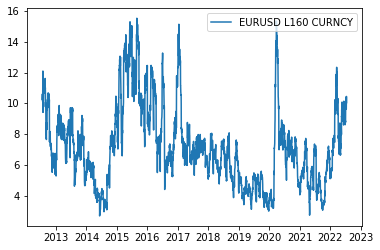

In [7]:
vol = rolling_vol("EURUSD L160 CURNCY", 3650, 0, 30)

In [8]:
markov_autoreg = sm.tsa.MarkovRegression(endog = vol, k_regimes = 3, switching_variance = True)

C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1D will be used.
  self._init_dates(dates, freq)
C:\Users\dramaswami\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
res_markov_autoreg = markov_autoreg.fit()

In [10]:
res_markov_autoreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:     EURUSD L160 CURNCY   No. Observations:                 3650
Model:               MarkovRegression   Log Likelihood               -5170.261
Date:                Sun, 17 Jul 2022   AIC                          10364.522
Time:                        11:56:28   BIC                          10438.952
Sample:                             0   HQIC                         10391.028
                               - 3650                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6305      0.029    160.500      0.000       4.574       4.687
sigma2         0.6522      0.030     21.973      0.000       0.594       0.710
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0655      0.025    279.380      0.000       7.016       7.115
sigma2         0.5055      0.024     21.472      0.000       0.459       0.552
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9485      0.071    153.573      0.000      10.809      11.088
sigma2         3.1809      0.161     19.707      0.000       2.865       3.497
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9864      0.000   6952.784      0.000       0.986       0.987
p[1->0]        0.0104      0.003      3.963      0.000       0.005       0.016
p[2->0]      5.39e-10        nan        nan        nan         nan         nan
p[0->1]        0.0136   4.51e-05    302.315      0.000       0.014       0.014
p[1->1]        0.9784      0.004    258.643      0.000       0.971       0.986
p[2->1]        0.0180      0.005      3.901      0.000       0.009       0.027
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

[73.28341739 46.34607996 55.6167569 ]


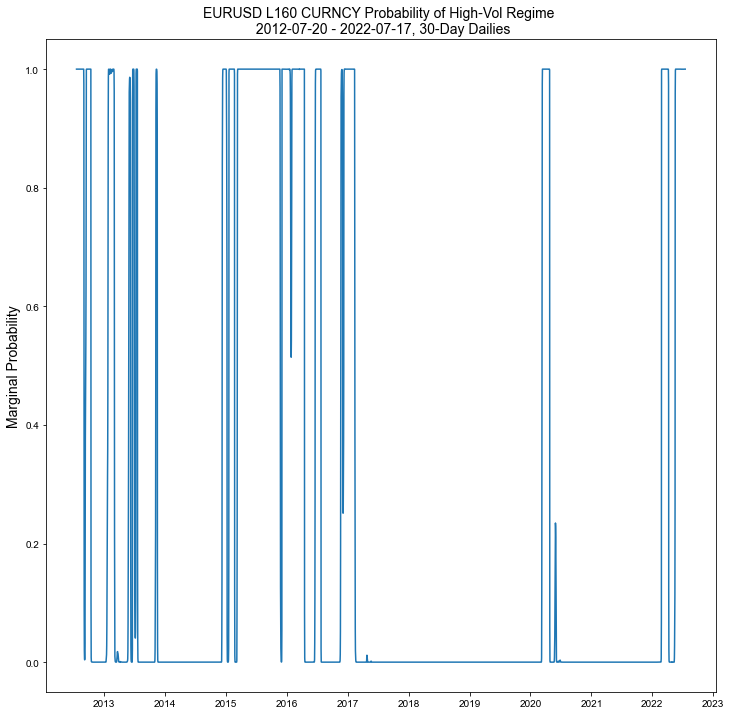

In [11]:

title_str = "%s Probability of High-Vol Regime \n %s - %s, 30-Day Dailies"%(vol.columns[0], vol.index[-1], vol.index[0])
plt.figure(figsize=(12,12))
sns.lineplot(y = res_markov_autoreg.smoothed_marginal_probabilities[2], x = vol.index)
sns.set_style("white")
plt.ylabel("Marginal Probability", fontsize = 14)
plt.title(title_str, fontsize = 14)

print(res_markov_autoreg.expected_durations)